In [2]:
import joblib
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Point

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import load_model

## 5.1. Configurações

In [3]:
# Estados do Brasil
gdf = gpd.read_file('../datas/external/brazil-states.geojson', encoding='utf-8')

# Estado da Paraíba
estado_gdf = gdf[gdf['name'] == 'Paraíba']

## 5.2. Funções

### 5.2.1. Gerador de Grade de Pontos

In [4]:
def gerador_de_df(estado_gdf, ano_inicial, ano_final):

    # Definir os limites da área de contorno
    contorno = estado_gdf.geometry.iloc[0]
    x_min, y_min, x_max, y_max = contorno.bounds

    # Criar uma lista para armazenar os pontos dentro do contorno
    pontos_dentro_contorno = []

    # Definir a quantidade de pontos na grade
    num_points = 200  # Aumente este número para uma grade mais fina

    # Gerar os pontos dentro da área de contorno
    for i in range(num_points):
        for j in range(num_points):
            x = x_min + i * (x_max - x_min) / (num_points - 1)
            y = y_min + j * (y_max - y_min) / (num_points - 1)
            point = Point(x, y)
            if contorno.contains(point):
                pontos_dentro_contorno.append((x, y))

    # Criando DataFrame
    latlon = []

    for i in range(len(pontos_dentro_contorno)):
        for j in range(1, 13):
            for k in range(ano_inicial, ano_final + 1):
                latlon.append({'lat': pontos_dentro_contorno[i][1],
                            'lon': pontos_dentro_contorno[i][0],
                            'ano': k,
                            'mes': j})

    return pd.DataFrame(latlon)

### 5.2.2. Gráfico de Chuvas

In [5]:
def grafico_de_chuvas(df: pd.DataFrame,
                      variavel: str,
                      unidade: str,
                      tamanho_dos_pontos: int,
                      tipo_dos_pontos: str = None):

    # Criar a figura
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plotar o mapa base do estado
    estado_gdf.plot(ax=ax, color='white', edgecolor='black')

    if tipo_dos_pontos == 'quadrado':

        # Plotar os dados preditos como uma imagem
        scatter = ax.scatter(df['lon'], df['lat'], c=df[variavel], cmap='viridis', alpha=0.8, s=tamanho_dos_pontos, edgecolors='none', marker='s')

    else:

        # Plotar os dados preditos como uma imagem
        scatter = ax.scatter(df['lon'], df['lat'], c=df[variavel], cmap='viridis', alpha=0.8, s=tamanho_dos_pontos, edgecolors='none')

    # Adicionar uma barra de cores
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.8, pad=0.01, fraction=0.0278)
    cbar.set_label(unidade)

    # Adicionar títulos e rótulos
    # plt.title('Mapa de Precipitação Mensal Anual Acumulada')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Mostrar o mapa
    plt.show()

### 5.2.3. Gŕafico de Dispersão

In [6]:
def dispersao(df, variavel_observada, variavel_predita):
    
    # Plotar gráfico de dispersão
    plt.figure(figsize=(8, 6))

    plt.scatter(df[variavel_observada], df[variavel_predita], alpha=0.5, color='#0b5ed7')

    plt.plot(
        [df[variavel_observada].min(),
         df[variavel_observada].max()],
        [df[variavel_observada].min(),
         df[variavel_observada].max()],
        'k--',
        label='Eixo de Paridade'
    )

    plt.xlabel('Precipitação Observada (mm)')
    plt.ylabel('Precipitação Predita (mm)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### 5.2.4. Gráfico Temporal

In [7]:
def linhas(df, variavel_observada, variavel_predita, variavel_data):

    plt.figure(figsize=(10, 6))

    sns.lineplot(data=df, x=variavel_data, y=variavel_observada, 
                label='Precipitação Geral Observada', 
                color='#0b5ed7', linewidth=1.5)

    sns.lineplot(data=df, x=variavel_data, y=variavel_predita, 
                label='Precipitação Geral Predita', 
                color='#000000', linewidth=1, linestyle='--')
    
    plt.xlim(df[variavel_data].min(), df[variavel_data].max())

    plt.legend()
    plt.ylabel('Precipitação Geral (mm)')
    plt.xlabel('Ano')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 5.3. Mapa de Precipitação Mensal Anual Acumulada (Dados Locais)

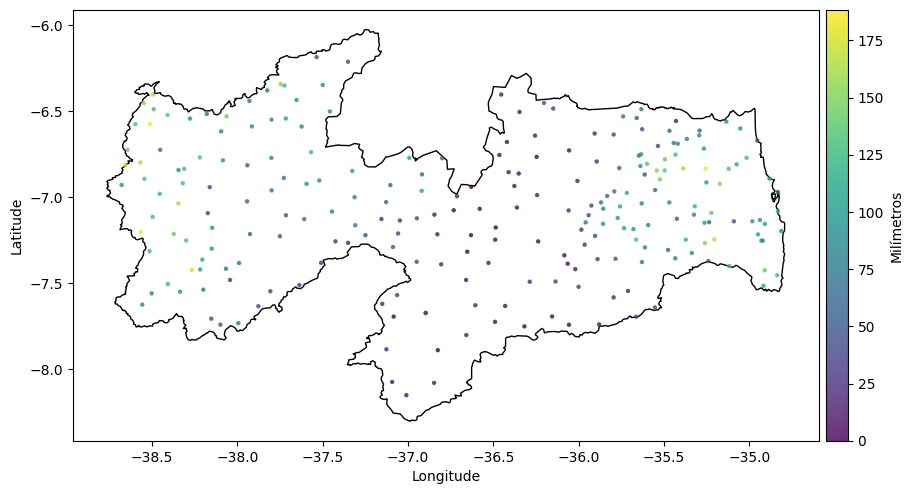

In [8]:
# Carregar os dados
df_aesa_sum = pd.read_csv("../datas/interim/2.3.1_aesa_database_create/aesa_1994-2023_mon_sum.csv")
df_aesa_sum = df_aesa_sum[(df_aesa_sum['ano'] == 2023) & (df_aesa_sum['mes'] == 1)]

grafico_de_chuvas(df_aesa_sum, 'pr_local', 'Milímetros', 10)

## 5.4. Mapa de Precipitação Mensal Anual Acumulada (Dados CMIP6)

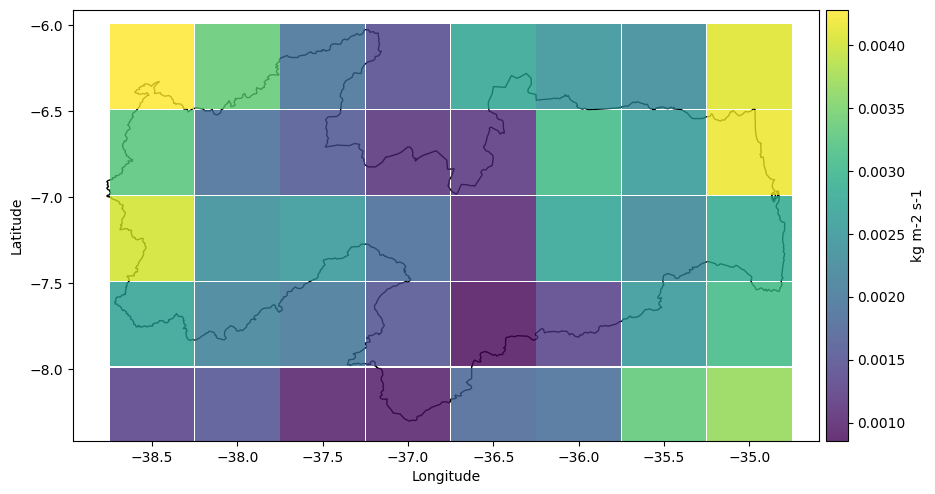

In [9]:
# Carregar os dados
df_cmip6_sum = pd.read_csv('../datas/interim/1.3.2_cmip6_database_create/pr_day_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_19940101-21001231_sum.csv')
df_aesa_sum = pd.read_csv("../datas/interim/2.3.1_aesa_database_create/aesa_1994-2023_mon_sum.csv")

df_cmip6_sum['lon'] = df_cmip6_sum['lon'] - 360
df_cmip6_sum = df_cmip6_sum[(df_cmip6_sum['lon'] <= df_aesa_sum['lon'].max()) &
                            (df_cmip6_sum['lon'] >= df_aesa_sum['lon'].min())]

df_cmip6_sum = df_cmip6_sum[(df_cmip6_sum['ano'] == 2023) & (df_cmip6_sum['mes'] == 1)]

grafico_de_chuvas(df_cmip6_sum, 'pr', 'kg m-2 s-1', 3700, 'quadrado')

## 5.5. Mapa de Precipitação Mensal Anual Acumulada (Dados de Redução de Escala)

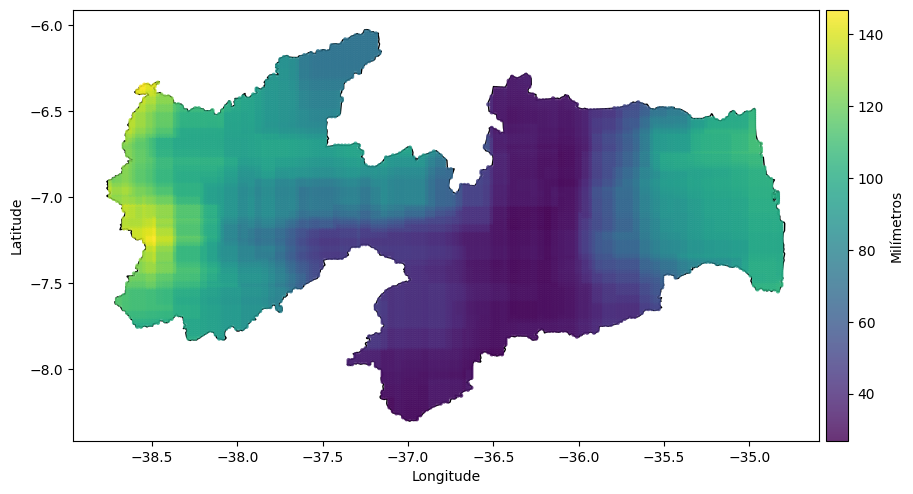

In [10]:
model = joblib.load("../models/statistical_downscaling_spatialization.joblib")

df_espacializado = gerador_de_df(estado_gdf, 2023, 2023)
df_espacializado = df_espacializado[model.feature_names_in_]
df_espacializado = df_espacializado[df_espacializado['mes'] == 1]
df_espacializado['pr'] = model.predict(df_espacializado)

grafico_de_chuvas(df_espacializado, 'pr', 'Milímetros', 10)

## 5.6. Análise de Modelo de Espacialização de Dados Locais

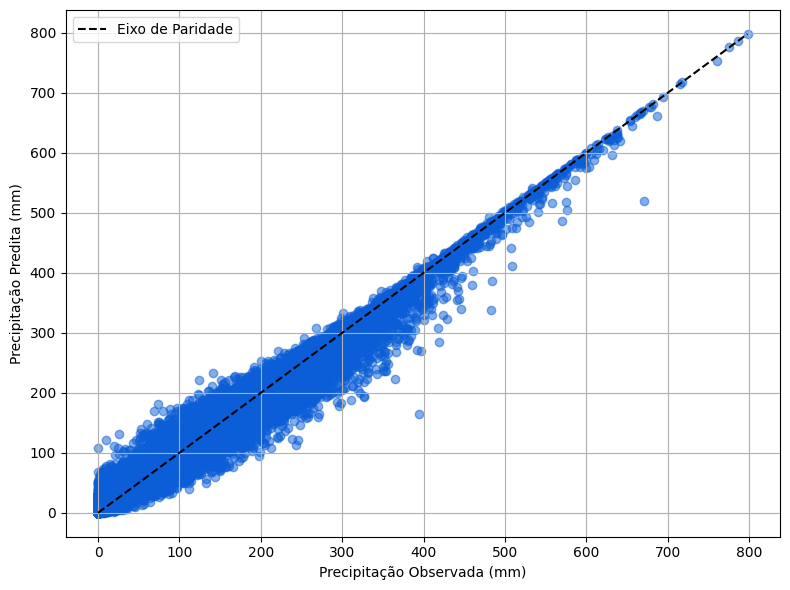

In [11]:
# Carregar dados preditos
model = joblib.load("../models/local_data_spatialization.joblib")

# Carregar modelo
df_aesa_sum = pd.read_csv(f'../datas/interim/3.2.1_aesa_with_idw/aesa_1994-2023_mon_sum_idw.csv')

# Calcular dados preditos
df_aesa_sum['pr'] = model.predict(df_aesa_sum[model.feature_names_in_])

# Gráfico do modelo
dispersao(df_aesa_sum, 'pr_local', 'pr')

## 5.7. Análise de Modelo de Redução de Escala

2025-05-17 16:35:07.221639: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


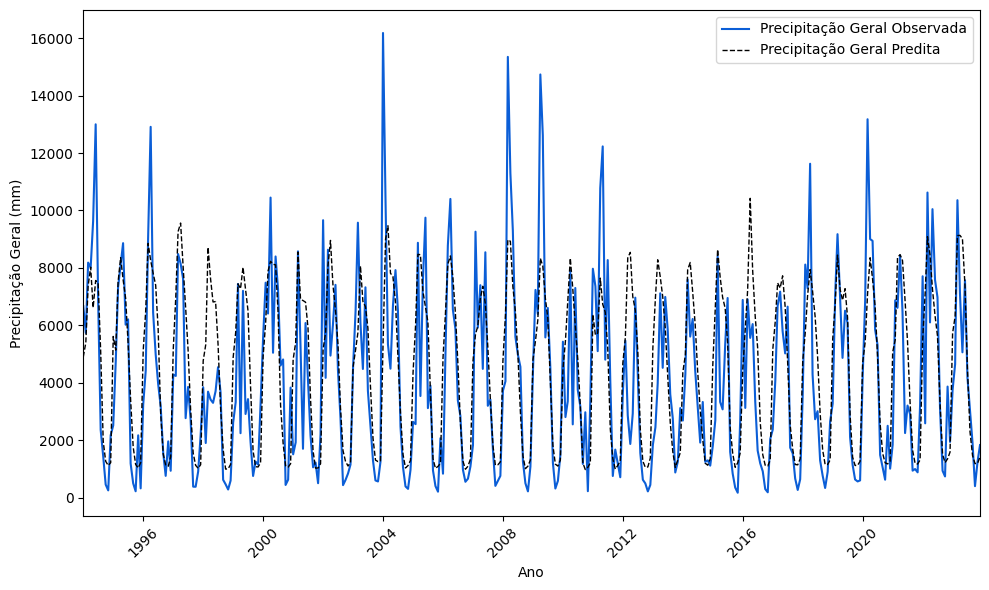

In [12]:
# Carrega o modelo
model = load_model('../models/statistical_downscaling.h5', compile=False)

# Lê os dados
df = pd.read_csv('../datas/interim/4.3.3_finish_downscaling_database/aesa_to_cnrm_cm6_1hr_sum_downscaling_complete.csv')

# Ajusta base de dados temporário
df_temp = df[df['ano'] <= 2023][['pr', 'pr_acum_6m', 'pr_mes_anterior', 'cluster', 'ano', 'mes', 'lat', 'lon', 'IDW']]

# Separa os dados de treino (ano <= 2023) para ajustar o scaler
X = df_temp.values

# Ajusta o scaler com os dados de treino
scaler = StandardScaler()
scaler.fit(
    df[df['ano'] <= 2023][['pr', 'pr_acum_6m', 'pr_mes_anterior', 'cluster', 'ano', 'mes', 'lat', 'lon', 'IDW']].values
)

# Aplica transformação
X = scaler.transform(X)

# Redimensiona para 3D
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Faz a predição
pr_test = model.predict(X).flatten()

# Ajustando base de dados principal
df = df[df['ano'] <= 2023]

# Adiciona predição da base de dados
df['pr_test'] = pr_test

# Ajustando data da base de dados
df['data'] = pd.to_datetime(df[['ano', 'mes']].rename(columns={'ano': 'year', 'mes': 'month'}).assign(day=1))

# Somando precipitações de todos os pontos com datas iguais
df_soma_total = df.groupby('data')[['pr_test', 'pr_local']].sum().reset_index()

# Gráfico do modelo
linhas(df_soma_total, 'pr_local', 'pr_test', 'data')

## 5.8. Análise de Modelo de Espacialização de Redução de Escala Estatística

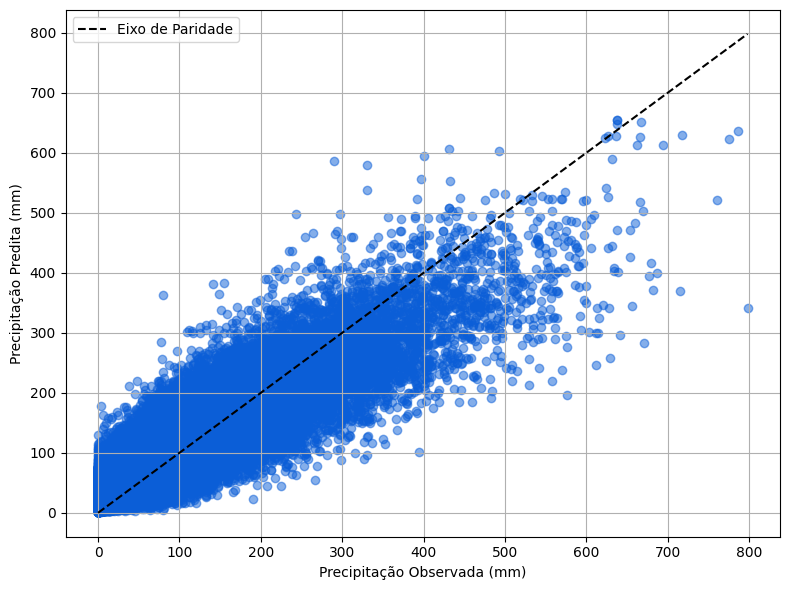

In [13]:
# Carregar dados preditos
model = joblib.load("../models/statistical_downscaling_spatialization.joblib")

# Carregar modelo
df_aesa_sum = pd.read_csv("../datas/interim/2.3.1_aesa_database_create/aesa_1994-2023_mon_sum.csv")

# Calcular dados preditos
df_aesa_sum['pr'] = model.predict(df_aesa_sum[model.feature_names_in_])

# Gráfico do modelo
dispersao(df_aesa_sum, 'pr_local', 'pr')